# 1- Importing Libraries

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Evauluation Metrics
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_curve, auc,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pickle
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 2 - Importing Dataset

In [398]:
df = pd.read_csv("../data/cleaned_data.csv")
df.sample(10)

,person_age,person_income,home_ownership_type,employement_duration,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,loan_default,credit_history_duration
30089,40.5,50000.0,MORTGAGE,2.0,DEBTCONSOLIDATION,B,5000.0,9.63,0,0.10,N,15.5
31866,36.0,140232.0,MORTGAGE,4.0,HOMEIMPROVEMENT,D,9400.0,15.62,0,0.04,Y,12.0
19690,27.0,36000.0,MORTGAGE,5.0,PERSONAL,A,5000.0,7.51,0,0.14,N,10.0
6332,22.0,29916.0,RENT,1.0,PERSONAL,D,6000.0,15.65,1,0.20,N,2.0
8610,23.0,25200.0,RENT,1.0,DEBTCONSOLIDATION,C,8000.0,12.73,1,0.32,N,4.0
22812,34.0,35000.0,RENT,9.0,DEBTCONSOLIDATION,A,8000.0,7.51,0,0.23,N,10.0
25738,28.0,91000.0,MORTGAGE,12.0,MEDICAL,C,21000.0,13.35,0,0.23,Y,6.0
891,23.0,23040.0,OWN,0.0,VENTURE,B,2000.0,11.11,0,0.09,N,3.0
23467,27.0,64800.0,MORTGAGE,12.0,VENTURE,A,6500.0,7.51,0,0.10,N,6.0
29605,38.0,37500.0,OTHER,0.0,EDUCATION,C,12000.0,13.47,1,0.32,Y,15.5


# 3- Encoding Categorical Variables

In [403]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import pandas as pd

# Step 1: One-Hot Encoding (with drop_first to avoid dummy variable trap)
ohe_ownership = OneHotEncoder(drop='first', sparse_output=False)
ohe_intent = OneHotEncoder(drop='first', sparse_output=False)

ownership_encoded = ohe_ownership.fit_transform(df[["home_ownership_type"]])
intent_encoded = ohe_intent.fit_transform(df[["loan_intent"]])

# Convert encoded arrays to DataFrames with proper column names
ownership_df = pd.DataFrame(ownership_encoded, columns=ohe_ownership.get_feature_names_out(["home_ownership_type"]))
intent_df = pd.DataFrame(intent_encoded, columns=ohe_intent.get_feature_names_out(["loan_intent"]))

# Set index to match original df
ownership_df.index = df.index
intent_df.index = df.index

# Step 2: Ordinal Encoding for loan_grade
ordinal = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
df['loan_grade_encoded'] = ordinal.fit_transform(df[['loan_grade']])

# Step 3: Drop original categorical columns
df_cleaned = df.drop(['home_ownership_type', 'loan_intent', 'loan_grade'], axis=1)

# Step 4: Concatenate everything into final dataset
df_encoded = pd.concat([df_cleaned, ownership_df, intent_df], axis=1)

# Step 5: Encode target variable
le = LabelEncoder()
df_encoded['loan_default'] = le.fit_transform(df_encoded['loan_default'])


# 4- Handling Imbalance in Dataset by Oversampling Techniquw

In [404]:
# Count how many records belong to each class
majority_count = len(df_encoded[df_encoded["loan_default"] == 0])
minority_count = len(df_encoded[df_encoded["loan_default"] == 1])

# Subset the actual data (not just boolean masks)
majority = df_encoded[df_encoded["loan_default"] == 0]
minority = df_encoded[df_encoded["loan_default"] == 1]


new_minority = minority.sample(majority_count,replace=True)
new_df = pd.concat([majority,new_minority],axis=0)
new_df["loan_default"].value_counts()

new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)


X_corr = df_encoded
X = new_df.drop('loan_default', axis=1)
y = new_df['loan_default']
X.shape


(53372, 17)

<Axes: >

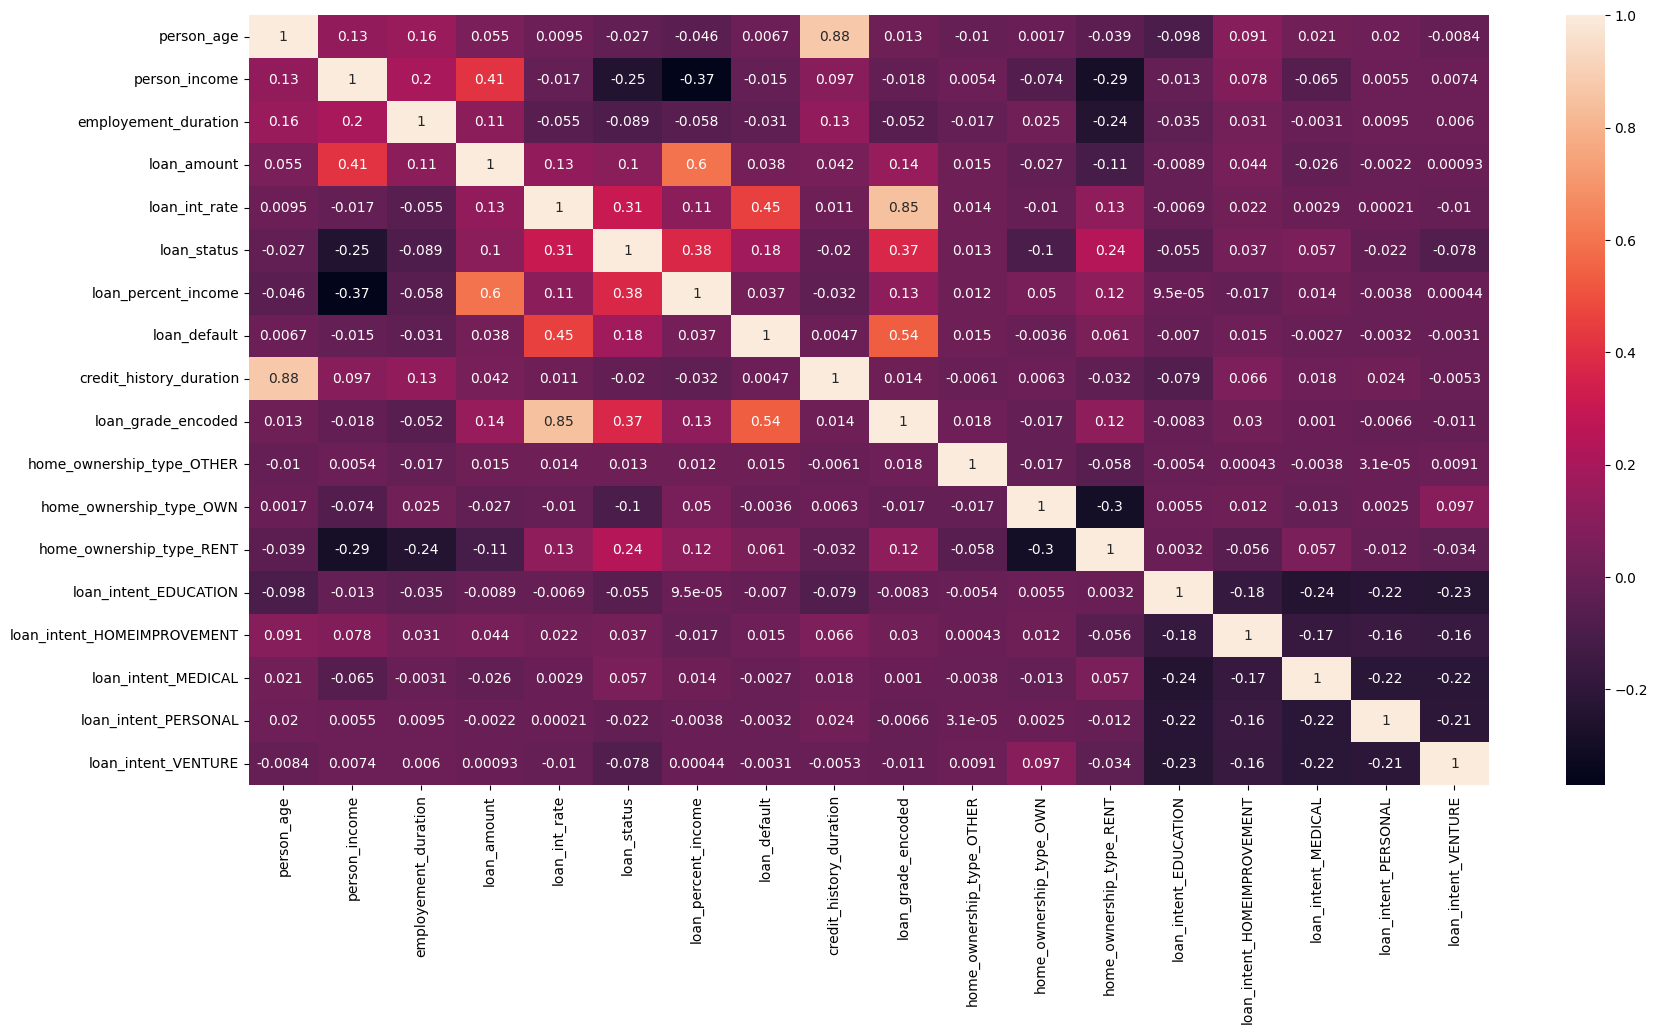

In [405]:
plt.figure(figsize=(20,10))
sns.heatmap(X_corr.corr(),annot=True)

# 5- Standardization/Scaling

In [406]:
X_train,X_test,y_train,y_test  =train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [407]:
from sklearn.preprocessing import StandardScaler
scaler  =StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5- Training/Predicting using Multiple Models

In [408]:
models = {
    "LogisticRegression": LogisticRegression(solver="saga", penalty="elasticnet", max_iter=10),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=0),
    "XGBClassifier": XGBClassifier(eval_metric="logloss", use_label_encoder=False)
}

params = {
    "LogisticRegression": {
        "l1_ratio": [0.0, 0.5, 1.0],
        "C": [0.1, 1, 10]
    },
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1]
    },
    "RandomForestClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [10, 30, 50],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "CatBoostClassifier": {
        "iterations": [100, 200],
        "depth": [4, 6, 10],
        "learning_rate": [0.01, 0.1]
    },
    "XGBClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1]
    }

}



for name, model in models.items():
    print(f"\n Running GridSearchCV for: {name}")
    grid = GridSearchCV(estimator=model, param_grid=params[name], cv=2, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"✅ Best Score: {grid.best_score_:.4f}")
    print(f"✅ Best Params: {grid.best_params_}")



 Running GridSearchCV for: LogisticRegression


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

✅ Best Score: 0.8874
✅ Best Params: {'C': 0.1, 'l1_ratio': 1.0}

 Running GridSearchCV for: AdaBoostClassifier


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

✅ Best Score: 0.8965
✅ Best Params: {'learning_rate': 0.1, 'n_estimators': 100}

 Running GridSearchCV for: RandomForestClassifier
✅ Best Score: 0.8967
✅ Best Params: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

 Running GridSearchCV for: CatBoostClassifier
✅ Best Score: 0.8966
✅ Best Params: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}

 Running GridSearchCV for: XGBClassifier


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:50:31] WARNING: /Users/runner/work/xgboost/xgboost/src

✅ Best Score: 0.8971
✅ Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1}


In [347]:
best_model = grid.best_estimator_


# Step 2: Train And Predict using out best model
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:15:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# 6 - Evaluation of Best Model

In [348]:
print(f"accuracy_score:{accuracy_score(y_test,y_pred)}")
print(f"f1:{f1_score(y_test,y_pred)}")
print(f"classification_report:{classification_report(y_test,y_pred)}")
print(f"confusion_matrix:{confusion_matrix(y_test,y_pred)}")

accuracy_score:0.9036972270796902
f1:0.9117647058823529
classification_report:              precision    recall  f1-score   support

           0       0.99      0.81      0.89      8006
           1       0.84      1.00      0.91      8006

    accuracy                           0.90     16012
   macro avg       0.92      0.90      0.90     16012
weighted avg       0.92      0.90      0.90     16012

confusion_matrix:[[6503 1503]
 [  39 7967]]


SInce there is huge Imbalance in dataset so Accuracy is not a reliable metrics here so We will rely on precision Recall Curve based on the Problem Statement where Getting to Know the Defaults are much more important than anything else in credit risk Modeling

# Using Precision/Recall Curve for Imbalanced Dataset Evaluation

In [359]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

# 1. Predict probabilities for class 1
y_prob = best_model.predict_proba(X_test)[:, 1]

# 2. Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# 3. ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

print(" ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


✅ ROC AUC: 0.9685269304329522
✅ PR AUC: 0.954426932647734


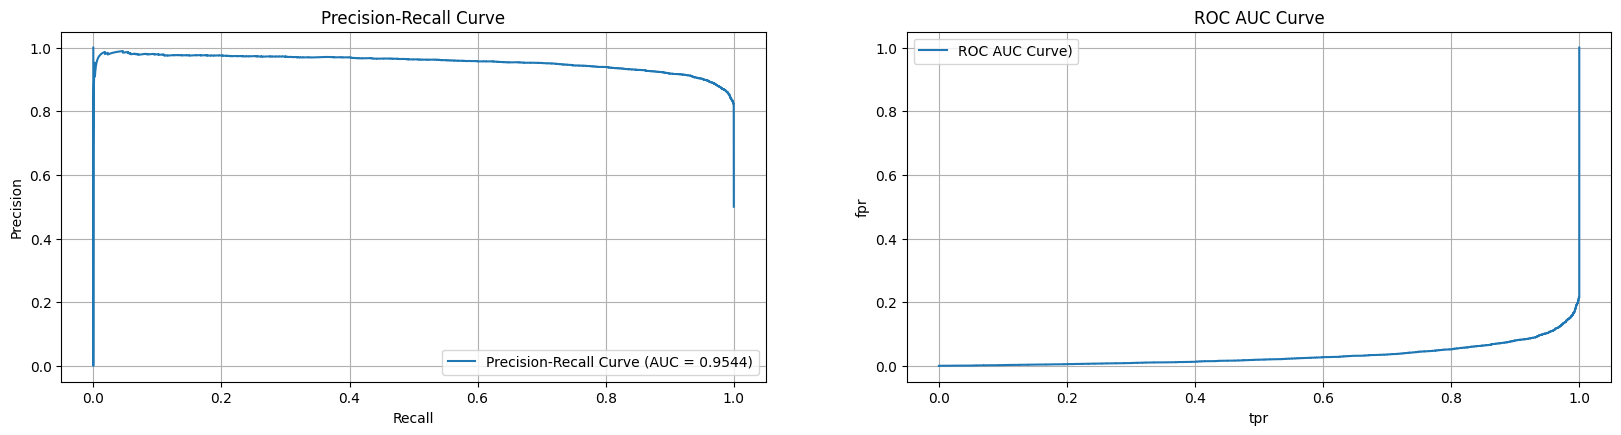

In [366]:
# 4 - Plotting Precision Recall Curve
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.plot(tpr, fpr, label=f'ROC AUC Curve)')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC AUC Curve')
plt.grid(True)
plt.legend()
plt.show()



In [424]:
comparing_prediction = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparing_prediction.sample(10)

,Actual,Predicted
17357,0,0
11878,1,1
41671,1,1
17301,1,1
6299,1,1
4801,1,1
17763,1,1
52756,0,0
45952,1,1
1911,0,0


# 7- Testing Our Model with New Input

In [425]:
# 1. Input new data
sample_input = {
    "person_age": 26.0,
    "person_income": 45000.0,
    "home_ownership_type": "RENT",
    "employement_duration": 2.0,
    "loan_intent": "PERSONAL",
    "loan_grade": "C",
    "loan_amount": 4800.0,
    "loan_int_rate": 13.06,
    "loan_status": 0,
    "loan_percent_income": 0.11,
    "credit_history_duration": 4.0
}

data = pd.DataFrame([sample_input])

# 2. Apply pre-fitted encoders (use .transform, NOT .fit_transform)
ownership_encoded = ohe_ownership.transform(data[["home_ownership_type"]])
intent_encoded = ohe_intent.transform(data[["loan_intent"]])

ownership_df = pd.DataFrame(ownership_encoded, columns=ohe_ownership.get_feature_names_out(["home_ownership_type"]))
intent_df = pd.DataFrame(intent_encoded, columns=ohe_intent.get_feature_names_out(["loan_intent"]))

# Set index to match data
ownership_df.index = data.index
intent_df.index = data.index

# 3. Ordinal encoding for loan_grade
data['loan_grade_encoded'] = ordinal.transform(data[['loan_grade']])

# 4. Drop unused original categorical columns
df_cleaned = data.drop(['home_ownership_type', 'loan_intent', 'loan_grade'], errors='ignore', axis=1)

# 5. Final input DataFrame
df_encoded = pd.concat([df_cleaned, ownership_df, intent_df], axis=1)

# 6. Scale
X_transformed = scaler.transform(df_encoded)

# 7. Predict
prediction = best_model.predict(X_transformed)[0]
print("Predicted loan default:", le.inverse_transform(np.array([prediction]))[0])



Predicted loan default: Y


# 8 - Model Explainability using SHAP/lIME